In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.9 MB/s eta 0:00:00


In [3]:
import os
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [4]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA A100-SXM4-40GB


#Lectura de datos

In [5]:
import pandas as pd
url='https://drive.google.com/file/d/1i-6kb6y9gETt6rZ_9XapZOY9RV5KXSLj/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
train = pd.read_csv(url).drop(columns=['Unnamed: 0', 'Longitud', 'Unnamed: 0.1'])


url1='https://drive.google.com/file/d/1-18w1iuu41336O5dL1NaBnL0rR4jMreZ/view?usp=sharing'
url1='https://drive.google.com/uc?id=' + url1.split('/')[-2]
test= pd.read_csv(url1).drop(columns=['Unnamed: 0'])

train = train.replace(to_replace='None', value=np.nan).dropna().reset_index()
test = test.replace(to_replace='None', value=np.nan).dropna().reset_index()

dataframes = {
  'train': train, 
  'test': test
}

In [ ]:
dataframes['train']['ideology_binary'].value_counts()

left     24108
right    18450
Name: ideology_binary, dtype: int64

In [ ]:
dataframes['train']['ideology_multiclass'].value_counts()

moderate_left     14038
moderate_right    12830
left              10070
right              5620
Name: ideology_multiclass, dtype: int64

##Binario

In [34]:
from sklearn.model_selection import train_test_split

X = list(dataframes['train']['V5'])
y = (dataframes['train']['ideology_binary'].map({'left':0, 'right':1}))
y=np.array(y,dtype=np.int16)

y_test= (dataframes['test']['ideology_binary'].map({'left':0, 'right':1}))

y_test=np.array(y_test,dtype=np.int16)

X_train, X_val, y_train, y_val =train_test_split(X, y, test_size=0.1, random_state=2023)

##Multiclase

In [66]:
from sklearn.model_selection import train_test_split

X = list(dataframes['train']['V5'])
y = (dataframes['train']['ideology_multiclass'].map({'left':0, 'moderate_left':1, 'moderate_right':2, 'right':3}))
y=np.array(y,dtype=np.int16)

#y_test=(test.ideology_binary.values)
y_test = (dataframes['test']['ideology_multiclass'].map({'left':0, 'moderate_left':1, 'moderate_right':2 ,'right':3}))
    
y_test=np.array(y_test,dtype=np.int16)

X_train, X_val, y_train, y_val =train_test_split(X, y, test_size=0.1, random_state=2023)

In [7]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text =text #= re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    #text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    #text = re.sub(r'\s+', ' ', text).strip()

    return text

from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data, MAX_LEN):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,  # Add `[CLS]` and `[SEP]`
            truncation=True ,      
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True     # Return attention mask        
              )
        
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks



In [67]:
# Concatenate train data and test data
all_tweets = np.concatenate([np.array(dataframes['train']['V5']), np.array(dataframes['test']['V5'])])
# Specify `MAX_LEN`
MAX_LEN = 400
# Encode our concatenated data
#encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True, max_length=MAX_LEN, truncation=True) for sent in all_tweets]
# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train, MAX_LEN )
val_inputs, val_masks = preprocessing_for_bert(X_val, MAX_LEN)

Tokenizing data...


In [68]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train,dtype=torch.int64) ####64
val_labels = torch.tensor(y_val,dtype=torch.int64)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [43]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=True):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 382, 4

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4, freeze_bert=True):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

#Funcion para replicabilidad
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

CPU times: user 120 µs, sys: 0 ns, total: 120 µs
Wall time: 125 µs


In [44]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [69]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(test.V5, MAX_LEN)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


## Entrenamiento original

### Binario

In [13]:
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(2022)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2, freeze_bert = False)
train(bert_classifier, full_train_dataloader, epochs=2)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.we

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.692112   |     -      |     -     |   15.19  
   1    |   40    |   0.678856   |     -      |     -     |   10.75  
   1    |   60    |   0.705114   |     -      |     -     |   10.75  
   1    |   80    |   0.707861   |     -      |     -     |   10.75  
   1    |   100   |   0.655737   |     -      |     -     |   10.76  
   1    |   120   |   0.629492   |     -      |     -     |   10.75  
   1    |   140   |   0.664609   |     -      |     -     |   10.74  
   1    |   160   |   0.644058   |     -      |     -     |   10.74  
   1    |   180   |   0.641090   |     -      |     -     |   10.74  
   1    |   200   |   0.608992   |     -      |     -     |   10.74  
   1    |   220   |   0.631406   |     -      |     -     |   10.74  
   1    |   240   |   0.596376   |     -      |     -     |   10.74  


In [14]:
#Calculamos la matriz de probabilidades para el conjunto de prueba
probs = bert_predict(bert_classifier, test_dataloader)
#Lista de indices que guarda las clases donde ocurre la max probabilidad para cada oracion
y_pred = []
for i in range(probs.shape[0]):
  #Guardamos las probabilidad de pertenecer a cada clase del blog
  input_list = list(probs[i])
  #Obtenemos el indice donde ocurre la mayor probabilidad
  index = input_list.index(max(input_list))
  #Guardamos el indice donde haya ocurrido
  y_pred.append(index)

In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
#yhat_CONV=candidato1

#Algunas metricas medias
print('Accuracy', accuracy_score(y_test,y_pred))
print('F1-Score', np.mean(f1_score(y_test,y_pred, average='macro')))

print("\nConfusion Matrix : ")
print(confusion_matrix(y_test,y_pred))

Accuracy 0.921
F1-Score 0.9008283967215625

Confusion Matrix : 
[[235  15]
 [ 64 686]]


### Multiclase

In [46]:
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(2022)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2, freeze_bert = False)
train(bert_classifier, full_train_dataloader, epochs=2)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.we

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.342265   |     -      |     -     |   11.32  
   1    |   40    |   1.284813   |     -      |     -     |   10.75  
   1    |   60    |   1.246265   |     -      |     -     |   10.74  
   1    |   80    |   1.206344   |     -      |     -     |   10.74  
   1    |   100   |   1.227196   |     -      |     -     |   10.75  
   1    |   120   |   1.206384   |     -      |     -     |   10.75  
   1    |   140   |   1.167439   |     -      |     -     |   10.75  
   1    |   160   |   1.210214   |     -      |     -     |   10.75  
   1    |   180   |   1.164365   |     -      |     -     |   10.74  
   1    |   200   |   1.181552   |     -      |     -     |   10.75  
   1    |   220   |   1.115569   |     -      |     -     |   10.75  
   1    |   240   |   1.140605   |     -      |     -     |   10.74  


In [47]:
#Calculamos la matriz de probabilidades para el conjunto de prueba
probs = bert_predict(bert_classifier, test_dataloader)
#Lista de indices que guarda las clases donde ocurre la max probabilidad para cada oracion
y_pred = []
for i in range(probs.shape[0]):
  #Guardamos las probabilidad de pertenecer a cada clase del blog
  input_list = list(probs[i])
  #Obtenemos el indice donde ocurre la mayor probabilidad
  index = input_list.index(max(input_list))
  #Guardamos el indice donde haya ocurrido
  y_pred.append(index)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
#yhat_CONV=candidato1

#Algunas metricas medias
print('Accuracy', accuracy_score(y_test,y_pred))
print('F1-Score', np.mean(f1_score(y_test,y_pred, average='macro')))

print("\nConfusion Matrix : ")
print(confusion_matrix(y_test,y_pred))

Accuracy 0.859
F1-Score 0.8181690903386375

Confusion Matrix : 
[[ 42   4   2   2]
 [  9 183   8   0]
 [ 11  29 438  22]
 [ 10  11  33 196]]


## Entrenamiento V1

### Binario

In [20]:
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(2022)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2, freeze_bert = False)
train(bert_classifier, full_train_dataloader, epochs=2)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.we

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.692168   |     -      |     -     |   11.33  
   1    |   40    |   0.684326   |     -      |     -     |   10.76  
   1    |   60    |   0.695084   |     -      |     -     |   10.76  
   1    |   80    |   0.684728   |     -      |     -     |   10.74  
   1    |   100   |   0.625707   |     -      |     -     |   10.74  
   1    |   120   |   0.632926   |     -      |     -     |   10.74  
   1    |   140   |   0.618761   |     -      |     -     |   10.74  
   1    |   160   |   0.620474   |     -      |     -     |   10.75  
   1    |   180   |   0.631614   |     -      |     -     |   10.75  
   1    |   200   |   0.591827   |     -      |     -     |   10.77  
   1    |   220   |   0.613972   |     -      |     -     |   10.75  
   1    |   240   |   0.591534   |     -      |     -     |   10.75  


In [21]:
#Calculamos la matriz de probabilidades para el conjunto de prueba
probs = bert_predict(bert_classifier, test_dataloader)
#Lista de indices que guarda las clases donde ocurre la max probabilidad para cada oracion
y_pred = []
for i in range(probs.shape[0]):
  #Guardamos las probabilidad de pertenecer a cada clase del blog
  input_list = list(probs[i])
  #Obtenemos el indice donde ocurre la mayor probabilidad
  index = input_list.index(max(input_list))
  #Guardamos el indice donde haya ocurrido
  y_pred.append(index)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
#yhat_CONV=candidato1

#Algunas metricas medias
print('Accuracy', accuracy_score(y_test,y_pred))
print('F1-Score', np.mean(f1_score(y_test,y_pred, average='macro')))

print("\nConfusion Matrix : ")
print(confusion_matrix(y_test,y_pred))

Accuracy 0.91
F1-Score 0.8855771235614502

Confusion Matrix : 
[[224  26]
 [ 64 686]]


### Multiclase

In [51]:
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(2022)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2, freeze_bert = False)
train(bert_classifier, full_train_dataloader, epochs=2)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.we

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.342265   |     -      |     -     |   11.33  
   1    |   40    |   1.284813   |     -      |     -     |   10.76  
   1    |   60    |   1.246265   |     -      |     -     |   10.76  
   1    |   80    |   1.206344   |     -      |     -     |   10.75  
   1    |   100   |   1.227196   |     -      |     -     |   10.74  
   1    |   120   |   1.206384   |     -      |     -     |   10.75  
   1    |   140   |   1.167439   |     -      |     -     |   10.75  
   1    |   160   |   1.210214   |     -      |     -     |   10.74  
   1    |   180   |   1.164365   |     -      |     -     |   10.75  
   1    |   200   |   1.181552   |     -      |     -     |   10.76  
   1    |   220   |   1.115569   |     -      |     -     |   10.74  
   1    |   240   |   1.140605   |     -      |     -     |   10.74  


In [52]:
#Calculamos la matriz de probabilidades para el conjunto de prueba
probs = bert_predict(bert_classifier, test_dataloader)
#Lista de indices que guarda las clases donde ocurre la max probabilidad para cada oracion
y_pred = []
for i in range(probs.shape[0]):
  #Guardamos las probabilidad de pertenecer a cada clase del blog
  input_list = list(probs[i])
  #Obtenemos el indice donde ocurre la mayor probabilidad
  index = input_list.index(max(input_list))
  #Guardamos el indice donde haya ocurrido
  y_pred.append(index)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
#yhat_CONV=candidato1

#Algunas metricas medias
print('Accuracy', accuracy_score(y_test,y_pred))
print('F1-Score', np.mean(f1_score(y_test,y_pred, average='macro')))

print("\nConfusion Matrix : ")
print(confusion_matrix(y_test,y_pred))

Accuracy 0.775
F1-Score 0.7137598283478829

Confusion Matrix : 
[[ 34  10   5   1]
 [ 15 162  23   0]
 [ 11  41 433  15]
 [ 10  26  68 146]]


## Entrenamiento V3

###Binario

In [26]:
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(2022)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2, freeze_bert = False)
train(bert_classifier, full_train_dataloader, epochs=2)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.we

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.694317   |     -      |     -     |   11.32  
   1    |   40    |   0.675708   |     -      |     -     |   10.75  
   1    |   60    |   0.690607   |     -      |     -     |   10.75  
   1    |   80    |   0.704403   |     -      |     -     |   10.75  
   1    |   100   |   0.680541   |     -      |     -     |   10.74  
   1    |   120   |   0.695444   |     -      |     -     |   10.74  
   1    |   140   |   0.685039   |     -      |     -     |   10.74  
   1    |   160   |   0.694838   |     -      |     -     |   10.74  
   1    |   180   |   0.694833   |     -      |     -     |   10.74  
   1    |   200   |   0.680445   |     -      |     -     |   10.74  
   1    |   220   |   0.692623   |     -      |     -     |   10.74  
   1    |   240   |   0.685811   |     -      |     -     |   10.74  


In [27]:
#Calculamos la matriz de probabilidades para el conjunto de prueba
probs = bert_predict(bert_classifier, test_dataloader)
#Lista de indices que guarda las clases donde ocurre la max probabilidad para cada oracion
y_pred = []
for i in range(probs.shape[0]):
  #Guardamos las probabilidad de pertenecer a cada clase del blog
  input_list = list(probs[i])
  #Obtenemos el indice donde ocurre la mayor probabilidad
  index = input_list.index(max(input_list))
  #Guardamos el indice donde haya ocurrido
  y_pred.append(index)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
#yhat_CONV=candidato1

#Algunas metricas medias
print('Accuracy', accuracy_score(y_test,y_pred))
print('F1-Score', np.mean(f1_score(y_test,y_pred, average='macro')))

print("\nConfusion Matrix : ")
print(confusion_matrix(y_test,y_pred))

Accuracy 0.586
F1-Score 0.5691072818787755

Confusion Matrix : 
[[194  56]
 [358 392]]


###Multiclase

In [58]:
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(2022)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2, freeze_bert = False)
train(bert_classifier, full_train_dataloader, epochs=2)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.we

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.343030   |     -      |     -     |   11.33  
   1    |   40    |   1.286020   |     -      |     -     |   10.76  
   1    |   60    |   1.247684   |     -      |     -     |   10.75  
   1    |   80    |   1.196907   |     -      |     -     |   10.75  
   1    |   100   |   1.230046   |     -      |     -     |   10.75  
   1    |   120   |   1.211397   |     -      |     -     |   10.75  
   1    |   140   |   1.166730   |     -      |     -     |   10.75  
   1    |   160   |   1.218780   |     -      |     -     |   10.75  
   1    |   180   |   1.176024   |     -      |     -     |   10.76  
   1    |   200   |   1.154930   |     -      |     -     |   10.74  
   1    |   220   |   1.121688   |     -      |     -     |   10.75  
   1    |   240   |   1.157961   |     -      |     -     |   10.75  


In [59]:
#Calculamos la matriz de probabilidades para el conjunto de prueba
probs = bert_predict(bert_classifier, test_dataloader)
#Lista de indices que guarda las clases donde ocurre la max probabilidad para cada oracion
y_pred = []
for i in range(probs.shape[0]):
  #Guardamos las probabilidad de pertenecer a cada clase del blog
  input_list = list(probs[i])
  #Obtenemos el indice donde ocurre la mayor probabilidad
  index = input_list.index(max(input_list))
  #Guardamos el indice donde haya ocurrido
  y_pred.append(index)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
#yhat_CONV=candidato1

#Algunas metricas medias
print('Accuracy', accuracy_score(y_test,y_pred))
print('F1-Score', np.mean(f1_score(y_test,y_pred, average='macro')))

print("\nConfusion Matrix : ")
print(confusion_matrix(y_test,y_pred))

Accuracy 0.834
F1-Score 0.7800947702750418

Confusion Matrix : 
[[ 40   6   2   2]
 [ 13 173  12   2]
 [ 16  38 432  14]
 [ 12  15  34 189]]


## Entrenamiento V4

### Binario

In [32]:
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(2022)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2, freeze_bert = False)
train(bert_classifier, full_train_dataloader, epochs=2)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.we

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.690620   |     -      |     -     |   11.31  
   1    |   40    |   0.671120   |     -      |     -     |   10.74  
   1    |   60    |   0.685231   |     -      |     -     |   10.75  
   1    |   80    |   0.676018   |     -      |     -     |   10.74  
   1    |   100   |   0.626749   |     -      |     -     |   10.74  
   1    |   120   |   0.633931   |     -      |     -     |   10.75  
   1    |   140   |   0.640931   |     -      |     -     |   10.74  
   1    |   160   |   0.615960   |     -      |     -     |   10.75  
   1    |   180   |   0.628035   |     -      |     -     |   10.76  
   1    |   200   |   0.601700   |     -      |     -     |   10.74  
   1    |   220   |   0.617671   |     -      |     -     |   10.74  
   1    |   240   |   0.574991   |     -      |     -     |   10.75  


In [33]:
#Calculamos la matriz de probabilidades para el conjunto de prueba
probs = bert_predict(bert_classifier, test_dataloader)
#Lista de indices que guarda las clases donde ocurre la max probabilidad para cada oracion
y_pred = []
for i in range(probs.shape[0]):
  #Guardamos las probabilidad de pertenecer a cada clase del blog
  input_list = list(probs[i])
  #Obtenemos el indice donde ocurre la mayor probabilidad
  index = input_list.index(max(input_list))
  #Guardamos el indice donde haya ocurrido
  y_pred.append(index)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
#yhat_CONV=candidato1

#Algunas metricas medias
print('Accuracy', accuracy_score(y_test,y_pred))
print('F1-Score', np.mean(f1_score(y_test,y_pred, average='macro')))

print("\nConfusion Matrix : ")
print(confusion_matrix(y_test,y_pred))

Accuracy 0.867
F1-Score 0.841515540414133

Confusion Matrix : 
[[233  17]
 [116 634]]


### Multiclase

In [64]:
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(2022)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2, freeze_bert = False)
train(bert_classifier, full_train_dataloader, epochs=2)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.we

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.340607   |     -      |     -     |   11.34  
   1    |   40    |   1.280833   |     -      |     -     |   10.75  
   1    |   60    |   1.249105   |     -      |     -     |   10.75  
   1    |   80    |   1.227017   |     -      |     -     |   10.76  
   1    |   100   |   1.259620   |     -      |     -     |   10.75  
   1    |   120   |   1.224737   |     -      |     -     |   10.75  
   1    |   140   |   1.179963   |     -      |     -     |   10.75  
   1    |   160   |   1.229809   |     -      |     -     |   10.76  
   1    |   180   |   1.168262   |     -      |     -     |   10.74  
   1    |   200   |   1.171983   |     -      |     -     |   10.74  
   1    |   220   |   1.139710   |     -      |     -     |   10.74  
   1    |   240   |   1.144723   |     -      |     -     |   10.74  


In [65]:
#Calculamos la matriz de probabilidades para el conjunto de prueba
probs = bert_predict(bert_classifier, test_dataloader)
#Lista de indices que guarda las clases donde ocurre la max probabilidad para cada oracion
y_pred = []
for i in range(probs.shape[0]):
  #Guardamos las probabilidad de pertenecer a cada clase del blog
  input_list = list(probs[i])
  #Obtenemos el indice donde ocurre la mayor probabilidad
  index = input_list.index(max(input_list))
  #Guardamos el indice donde haya ocurrido
  y_pred.append(index)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
#yhat_CONV=candidato1

#Algunas metricas medias
print('Accuracy', accuracy_score(y_test,y_pred))
print('F1-Score', np.mean(f1_score(y_test,y_pred, average='macro')))

print("\nConfusion Matrix : ")
print(confusion_matrix(y_test,y_pred))

Accuracy 0.777
F1-Score 0.7142703409190265

Confusion Matrix : 
[[ 39   3   3   5]
 [ 20 156  23   1]
 [ 23  41 416  20]
 [ 21  11  52 166]]


##Entrenamiento V5

###Binario

In [38]:
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(2022)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2, freeze_bert = False)
train(bert_classifier, full_train_dataloader, epochs=2)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.we

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.693160   |     -      |     -     |   11.34  
   1    |   40    |   0.683708   |     -      |     -     |   10.74  
   1    |   60    |   0.697869   |     -      |     -     |   10.74  
   1    |   80    |   0.683299   |     -      |     -     |   10.74  
   1    |   100   |   0.632744   |     -      |     -     |   10.75  
   1    |   120   |   0.655326   |     -      |     -     |   10.75  
   1    |   140   |   0.638759   |     -      |     -     |   10.75  
   1    |   160   |   0.641764   |     -      |     -     |   10.74  
   1    |   180   |   0.633436   |     -      |     -     |   10.74  
   1    |   200   |   0.622843   |     -      |     -     |   10.74  
   1    |   220   |   0.624595   |     -      |     -     |   10.75  
   1    |   240   |   0.600159   |     -      |     -     |   10.74  


In [39]:
#Calculamos la matriz de probabilidades para el conjunto de prueba
probs = bert_predict(bert_classifier, test_dataloader)
#Lista de indices que guarda las clases donde ocurre la max probabilidad para cada oracion
y_pred = []
for i in range(probs.shape[0]):
  #Guardamos las probabilidad de pertenecer a cada clase del blog
  input_list = list(probs[i])
  #Obtenemos el indice donde ocurre la mayor probabilidad
  index = input_list.index(max(input_list))
  #Guardamos el indice donde haya ocurrido
  y_pred.append(index)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
#yhat_CONV=candidato1

#Algunas metricas medias
print('Accuracy', accuracy_score(y_test,y_pred))
print('F1-Score', np.mean(f1_score(y_test,y_pred, average='macro')))

print("\nConfusion Matrix : ")
print(confusion_matrix(y_test,y_pred))

Accuracy 0.84
F1-Score 0.8112985021818611

Confusion Matrix : 
[[225  25]
 [135 615]]


###Multiclase

In [70]:
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(2022)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2, freeze_bert = False)
train(bert_classifier, full_train_dataloader, epochs=2)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.we

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.351655   |     -      |     -     |   11.31  
   1    |   40    |   1.328370   |     -      |     -     |   10.76  
   1    |   60    |   1.293068   |     -      |     -     |   10.75  
   1    |   80    |   1.267780   |     -      |     -     |   10.74  
   1    |   100   |   1.269483   |     -      |     -     |   10.75  
   1    |   120   |   1.249040   |     -      |     -     |   10.75  
   1    |   140   |   1.233827   |     -      |     -     |   10.75  
   1    |   160   |   1.283499   |     -      |     -     |   10.74  
   1    |   180   |   1.260871   |     -      |     -     |   10.75  
   1    |   200   |   1.242041   |     -      |     -     |   10.75  
   1    |   220   |   1.212617   |     -      |     -     |   10.76  
   1    |   240   |   1.230015   |     -      |     -     |   10.75  


In [71]:
#Calculamos la matriz de probabilidades para el conjunto de prueba
probs = bert_predict(bert_classifier, test_dataloader)
#Lista de indices que guarda las clases donde ocurre la max probabilidad para cada oracion
y_pred = []
for i in range(probs.shape[0]):
  #Guardamos las probabilidad de pertenecer a cada clase del blog
  input_list = list(probs[i])
  #Obtenemos el indice donde ocurre la mayor probabilidad
  index = input_list.index(max(input_list))
  #Guardamos el indice donde haya ocurrido
  y_pred.append(index)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
#yhat_CONV=candidato1

#Algunas metricas medias
print('Accuracy', accuracy_score(y_test,y_pred))
print('F1-Score', np.mean(f1_score(y_test,y_pred, average='macro')))

print("\nConfusion Matrix : ")
print(confusion_matrix(y_test,y_pred))

Accuracy 0.766
F1-Score 0.7034721243209622

Confusion Matrix : 
[[ 37   6   6   1]
 [ 13 173  14   0]
 [ 18  68 387  27]
 [ 36  12  33 169]]


# Aplicacion politica mexico

In [ ]:
Alfaro_Ola1=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/Alfaro B.xlsx', sheet_name='Ola 1').iloc[: , :9]
Alfaro_Ola2=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/Alfaro B.xlsx', sheet_name='Ola 2').iloc[: , :9]
Alfaro_Ola3=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/Alfaro B.xlsx', sheet_name='Ola 3').iloc[: , :9]
Sheibaum_Ola1=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/ClaudiaShein B.xlsx', sheet_name='Ola 1').iloc[: , :9]
Sheibaum_Ola2=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/ClaudiaShein B.xlsx', sheet_name='Ola 2').iloc[: , :9]#Content
Sheibaum_Ola3=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/ClaudiaShein B.xlsx', sheet_name='Ola 3').iloc[: , :9]
Sinhue_Ola1=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/diegosinhue B.xlsx', sheet_name='Ola 1').iloc[: , :9]
Sinhue_Ola2=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/diegosinhue B.xlsx', sheet_name='Ola 2').iloc[: , :9]
Sinhue_Ola3=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/diegosinhue B.xlsx', sheet_name='Ola 3').iloc[: , :9]
Cuitlahuac_Ola1=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/CuitlahuacGJ B.xlsx', sheet_name='Ola 1').iloc[: , :9]
Cuitlahuac_Ola2=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/CuitlahuacGJ B.xlsx', sheet_name='Ola 2').iloc[: , :9]#content
Cuitlahuac_Ola3=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/CuitlahuacGJ B.xlsx', sheet_name='Ola 3').iloc[: , :9]
Sinhue_Ola1=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/diegosinhue B.xlsx', sheet_name='Ola 1').iloc[: , :9]
Sinhue_Ola2=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/diegosinhue B.xlsx', sheet_name='Ola 2').iloc[: , :9]
Sinhue_Ola3=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/diegosinhue B.xlsx', sheet_name='Ola 3').iloc[: , :9]
Gattel_Ola1=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/HLGatell B.xlsx', sheet_name='Ola 1').iloc[: , :9]
Gattel_Ola2=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/HLGatell B.xlsx', sheet_name='Ola2').iloc[: , :9]
Gattel_Ola3=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/HLGatell B.xlsx', sheet_name='Ola 3').iloc[: , :9]
Jaime_Ola1=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/JaimeRdzNL B.xlsx', sheet_name='Ola 1')
Jaime_Ola2=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/JaimeRdzNL B.xlsx', sheet_name='Ola 2')
Jaime_Ola3=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/JaimeRdzNL B.xlsx', sheet_name='Ola 3')
Amlo_Ola1=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/lopezobrador_B.xlsx', sheet_name='Ola 1').iloc[: , :9]
Amlo_Ola2=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/lopezobrador_B.xlsx', sheet_name='Ola 2').iloc[: , :9]
Amlo_Ola3=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/lopezobrador_B.xlsx', sheet_name='Ola 3').iloc[: , :9]
Alfredo_Ola1 = pd.read_csv('/content/drive/MyDrive/Politicos_tweets/AlfredoDelMazo_1.csv').iloc[: , :8]
Alfredo_Ola2 = pd.read_csv('/content/drive/MyDrive/Politicos_tweets/AlfredoDelMazo_2.csv').iloc[: , :8]
Alfredo_Ola3 = pd.read_csv('/content/drive/MyDrive/Politicos_tweets/AlfredoDelMazo_3.csv').iloc[: , :8]
MBarbosa_Ola1 = pd.read_excel('/content/drive/MyDrive/Politicos_tweets/MBarbosaMX_B.xlsx',sheet_name='Ola1' ).iloc[: , :8]
MBarbosa_Ola2 = pd.read_excel('/content/drive/MyDrive/Politicos_tweets/MBarbosaMX_B.xlsx',sheet_name='Ola2' ).iloc[: , :8]
MBarbosa_Ola3 = pd.read_excel('/content/drive/MyDrive/Politicos_tweets/MBarbosaMX_B.xlsx',sheet_name='Ola3' ).iloc[: , :8]
Alejandro_Ola1 = pd.read_excel('/content/drive/MyDrive/Politicos_tweets/alejandromurat B.xlsx',sheet_name='Ola1' ).iloc[: , :8]
Alejandro_Ola2 = pd.read_excel('/content/drive/MyDrive/Politicos_tweets/alejandromurat B.xlsx',sheet_name='Ola2' ).iloc[: , :8]
Alejandro_Ola3 = pd.read_excel('/content/drive/MyDrive/Politicos_tweets/alejandromurat B.xlsx',sheet_name='Ola3' ).iloc[: , :8]

Alfaro_Ola1['tag']='Alfaro_Ola1'
Alfaro_Ola2['tag']='Alfaro_Ola2'
Alfaro_Ola3['tag']='Alfaro_Ola3'
Alfredo_Ola1['tag']='Alfredo_Ola1'
Alfredo_Ola2['tag']='Alfredo_Ola2'
Alfredo_Ola3['tag']='Alfredo_Ola3'
Sheibaum_Ola1['tag']='Sheibaum_Ola1'
Sheibaum_Ola2['tag']='Sheibaum_Ola2'
Sheibaum_Ola3['tag']='Sheibaum_Ola3'
Cuitlahuac_Ola1['tag']='Cuitlahuac_Ola1'
Cuitlahuac_Ola2['tag']='Cuitlahuac_Ola2'
Cuitlahuac_Ola3['tag']='Cuitlahuac_Ola3'
Sinhue_Ola1['tag']='Sinhue_Ola1'
Sinhue_Ola2['tag']='Sinhue_Ola2'
Sinhue_Ola3['tag']='Sinhue_Ola3'
Gattel_Ola1['tag']='Gattel_Ola1'
Gattel_Ola2['tag']='Gattel_Ola2'
Gattel_Ola3['tag']='Gattel_Ola3'
Jaime_Ola1['tag']='Jaime_Ola1'
Jaime_Ola2['tag']='Jaime_Ola2'
Jaime_Ola3['tag']='Jaime_Ola3'
Amlo_Ola1['tag']='Amlo_Ola1'
Amlo_Ola2['tag']='Amlo_Ola2'
Amlo_Ola3['tag']='Amlo_Ola3'
MBarbosa_Ola1['tag']='Barbosa_Ola1'
MBarbosa_Ola2['tag']='Barbosa_Ola2'
MBarbosa_Ola3['tag']='Barbosa_Ola3'

Alejandro_Ola1['tag']='Alejandro_Ola1'
Alejandro_Ola2['tag']='Alejandro_Ola2'
Alejandro_Ola3['tag']='Alejandro_Ola3'


Alfaro_Ola1=Alfaro_Ola1[['Tweet', 'tag']].rename(columns={"Tweet": "Content"})
Alfaro_Ola2=Alfaro_Ola2[['Tweet', 'tag']].rename(columns={"Tweet": "Content"})
Alfaro_Ola3=Alfaro_Ola3[['Tweet', 'tag']].rename(columns={"Tweet": "Content"})
Sheibaum_Ola1=Sheibaum_Ola1[['Tweet', 'tag']].rename(columns={"Tweet": "Content"})
Sheibaum_Ola2=Sheibaum_Ola2[['Tweet', 'tag']].rename(columns={"Tweet": "Content"})
Sheibaum_Ola3=Sheibaum_Ola3[['Tweet', 'tag']].rename(columns={"Tweet": "Content"})
Cuitlahuac_Ola1=Cuitlahuac_Ola1[['Tweet', 'tag']].rename(columns={"Tweet": "Content"})
Cuitlahuac_Ola2=Cuitlahuac_Ola2[['Content', 'tag']]
Cuitlahuac_Ola3=Cuitlahuac_Ola3[['Tweet', 'tag']].rename(columns={"Tweet": "Content"})
Sinhue_Ola1=Sinhue_Ola1[['Tweet', 'tag']].rename(columns={"Tweet": "Content"})
Sinhue_Ola2=Sinhue_Ola2[['Content', 'tag']]
Sinhue_Ola3=Sinhue_Ola3[['Tweet', 'tag']].rename(columns={"Tweet": "Content"})
Gattel_Ola1=Gattel_Ola1[['Content', 'tag']]
Gattel_Ola2=Gattel_Ola2[['Content', 'tag']]
Gattel_Ola3=Gattel_Ola3[['Content', 'tag']]
Jaime_Ola1=Jaime_Ola1[['Content', 'tag']]
Jaime_Ola2=Jaime_Ola2[['Content', 'tag']]
Jaime_Ola3=Jaime_Ola3[['Content', 'tag']]
Amlo_Ola1=Amlo_Ola1[['Content', 'tag']]
Amlo_Ola2=Amlo_Ola2[['Content', 'tag']]
Amlo_Ola3=Amlo_Ola3[['Content', 'tag']]
Alfredo_Ola1=Alfredo_Ola1[['Tweet', 'tag']].rename(columns={"Tweet": "Content"})
Alfredo_Ola2=Alfredo_Ola2[['Content', 'tag']]
Alfredo_Ola3=Alfredo_Ola3[['Tweet', 'tag']].rename(columns={"Tweet": "Content"})
MBarbosa_Ola1=MBarbosa_Ola1[['Tweet', 'tag']].rename(columns={"Tweet": "Content"})
MBarbosa_Ola2=MBarbosa_Ola2[['Tweet', 'tag']].rename(columns={"Tweet": "Content"})
MBarbosa_Ola3=MBarbosa_Ola3[['Tweet', 'tag']].rename(columns={"Tweet": "Content"})
Alejandro_Ola1=Alejandro_Ola1[['Tweet', 'tag']].rename(columns={"Tweet": "Content"})
Alejandro_Ola2=Alejandro_Ola2[['Tweet', 'tag']].rename(columns={"Tweet": "Content"})
Alejandro_Ola3=Alejandro_Ola3[['Tweet', 'tag']].rename(columns={"Tweet": "Content"})

train_Ola1=pd.concat([Alfaro_Ola1, Sheibaum_Ola1,Cuitlahuac_Ola1, Sinhue_Ola1, Gattel_Ola1,  Jaime_Ola1, Amlo_Ola1, Alfredo_Ola1, MBarbosa_Ola1, Alejandro_Ola1], axis=0)
train_Ola1=train_Ola1.dropna()
train_Ola1=train_Ola1.reset_index().drop(columns='index')

train_Ola2=pd.concat([Alfaro_Ola2,  Sheibaum_Ola2,  Cuitlahuac_Ola2, Sinhue_Ola2, Gattel_Ola2,  Jaime_Ola2, Amlo_Ola2,  Alfredo_Ola2, MBarbosa_Ola2,Alejandro_Ola2], axis=0)
train_Ola2=train_Ola2.dropna()
train_Ola2=train_Ola2.reset_index().drop(columns='index')

train_Ola3=pd.concat([Alfaro_Ola3,  Sheibaum_Ola3,  Cuitlahuac_Ola3, Sinhue_Ola3, Gattel_Ola3, Jaime_Ola3, Amlo_Ola3, Alfredo_Ola3, MBarbosa_Ola3, Alejandro_Ola3], axis=0)
train_Ola3=train_Ola3.dropna()
train_Ola3=train_Ola3.reset_index().drop(columns='index')

politics_merged=pd.concat([train_Ola1, train_Ola2, train_Ola3], axis=0).reset_index().drop(columns='index')

In [ ]:
longitud=[len(x.split()) for x in politics_merged['Content']]
politics_merged['longitud']=longitud

<Axes: >

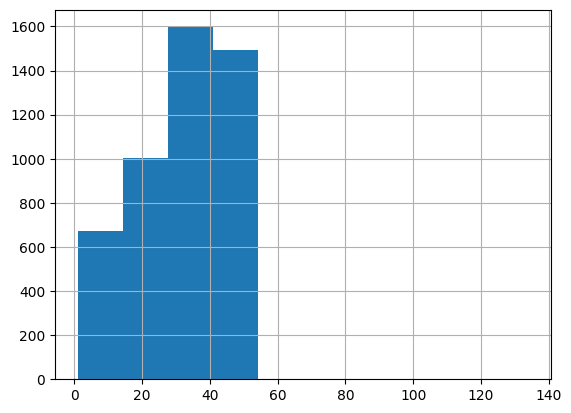

In [ ]:
politics_merged['longitud'].hist()

In [ ]:
# Install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Last version of Spar
!wget -q https://dlcdn.apache.org/spark/spark-3.2.4/spark-3.2.4-bin-hadoop3.2.tgz -O file.tgz

# Unzip spark /content/spark-3.2.4-bin-hadoop3.2.tgz
!tar zxvf  file.tgz

# Setting environment variable
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

# Install findspark lib that help find spark in the system and import it as a regular lib
!pip install -q findspark
os.environ["SPARK_HOME"] = "/content/spark-3.2.4-bin-hadoop3.2"

# Import findspark lib 
import findspark
findspark.init()

from pyspark import SparkContext
sc = SparkContext()

In [ ]:
#resumen=[generate_summary(texto) for texto in df['Procesado']]
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz
# install findspark using pip
!pip install -q findspark

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

import findspark
findspark.init()

from pyspark import SparkContext
sc = SparkContext()

In [ ]:
import re
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)


def Propuesta3(text):
  text=text.lower()
  #Ahora removemos emojis
  text=remove_emojis(text)
  #Si encuentra algun Hashtag, lo remueve
  newlist=[]
  for i,word in enumerate(text.split()):
    if(word[0]=='#'):
      word=word.replace("#", "")
    else:
      newlist.append(word)
  text=' '.join(newlist)
  text=text.replace(".", "")
  text=text.replace(",", "")
  text=text.replace("'", "")
  
  return(text)

#Predicciones Binarias

In [ ]:
#X_rdd=sc.parallelize(politics_merged['Content'])
#Tweets_procesados=X_rdd.map(Propuesta3).collect()
#politics_merged['Procesado']=Tweets_procesados

In [ ]:
MAX_LEN

200

In [ ]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(politics_merged.Content, 200 )

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


In [ ]:
#Calculamos la matriz de probabilidades para el conjunto de prueba
probs = bert_predict(bert_classifier, test_dataloader)
#Lista de indices que guarda las clases donde ocurre la max probabilidad para cada oracion
y_pred = []
for i in range(probs.shape[0]):
  #Guardamos las probabilidad de pertenecer a cada clase del blog
  input_list = list(probs[i])
  #Obtenemos el indice donde ocurre la mayor probabilidad
  index = input_list.index(max(input_list))
  #Guardamos el indice donde haya ocurrido
  y_pred.append(index)

In [ ]:
politics_merged['ideology_binary']=y_pred
politics_merged['ideology_binary']=politics_merged['ideology_binary'].map({0: 'left', 1:'moderate_left', 2: 'moderate_right' , 3:'right'})
politics_merged.to_csv('Resultados_binario.csv')

### Ajustado 100 tokens

<Axes: >

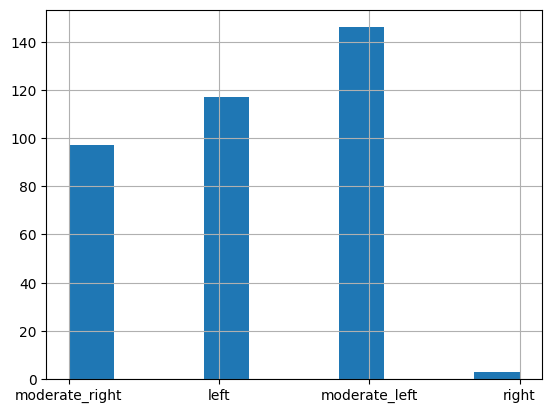

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Alfaro_Ola1'].hist()

<Axes: >

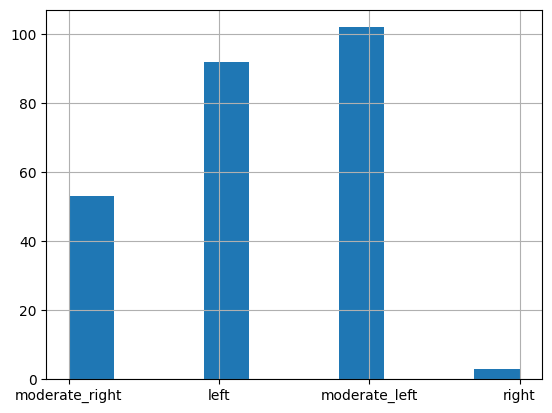

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Alfaro_Ola2'].hist()

<Axes: >

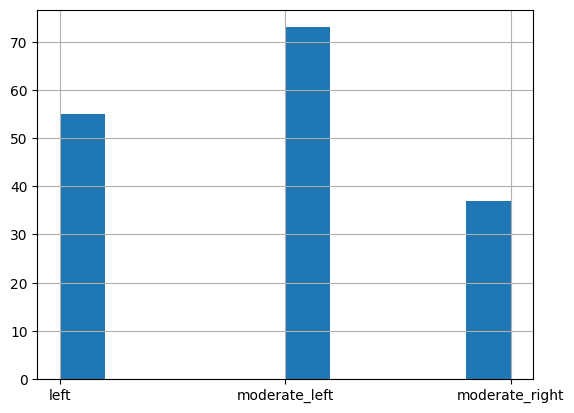

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Alfaro_Ola3'].hist()

<Axes: >

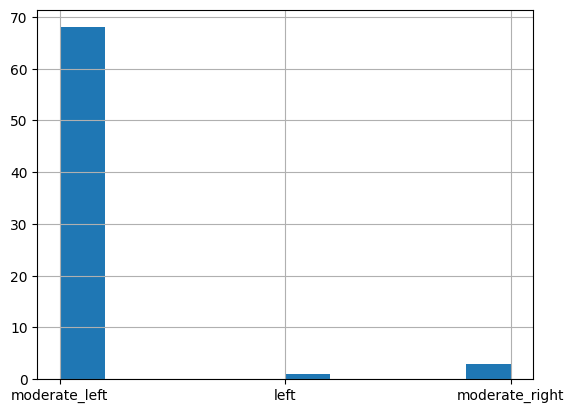

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Alfredo_Ola1'].hist()

<Axes: >

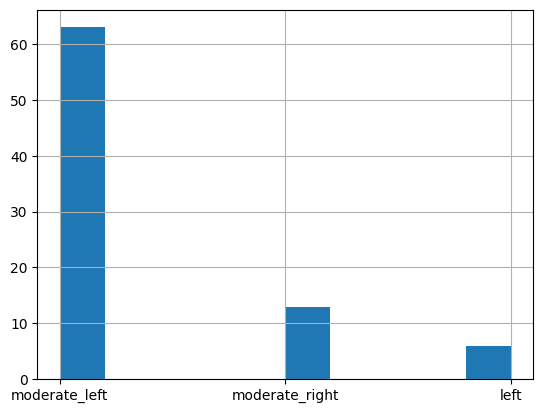

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Alfredo_Ola2'].hist()

<Axes: >

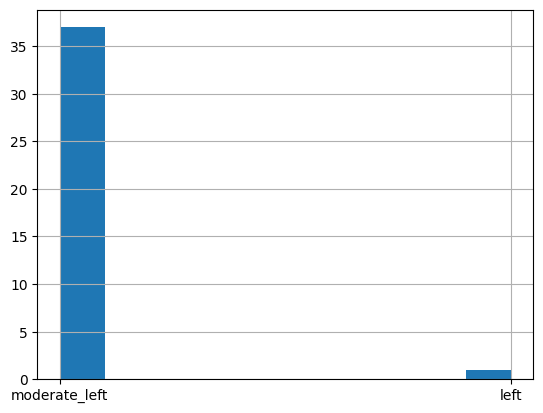

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Alfredo_Ola3'].hist()

<Axes: >

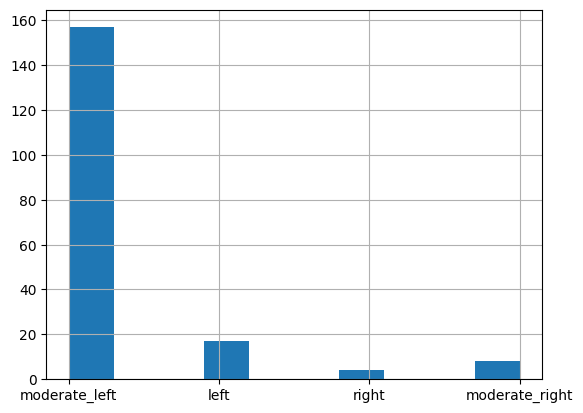

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Sheibaum_Ola1'].hist()

<Axes: >

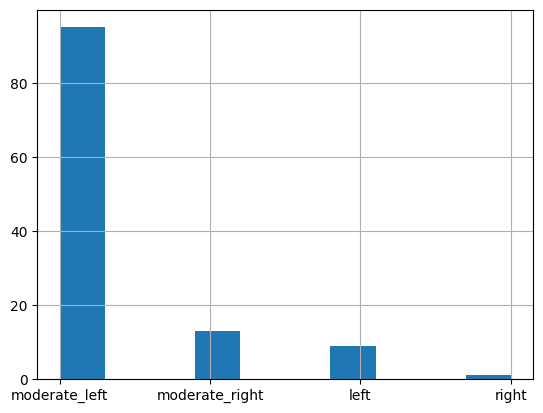

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Sheibaum_Ola2'].hist()

<Axes: >

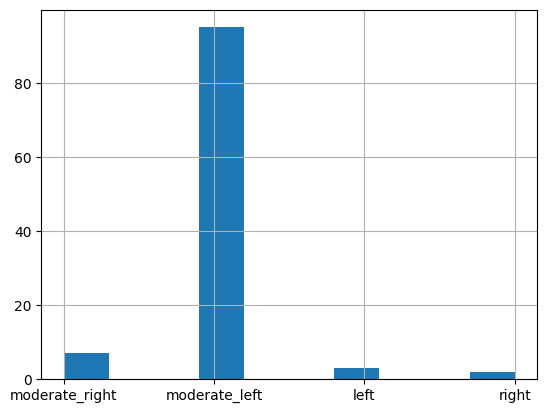

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Sheibaum_Ola3'].hist()

<Axes: >

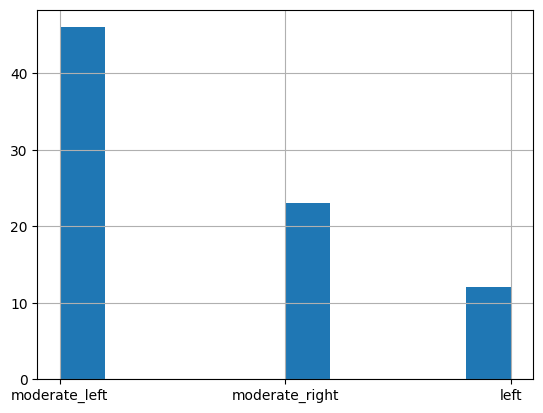

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Cuitlahuac_Ola1'].hist()

<Axes: >

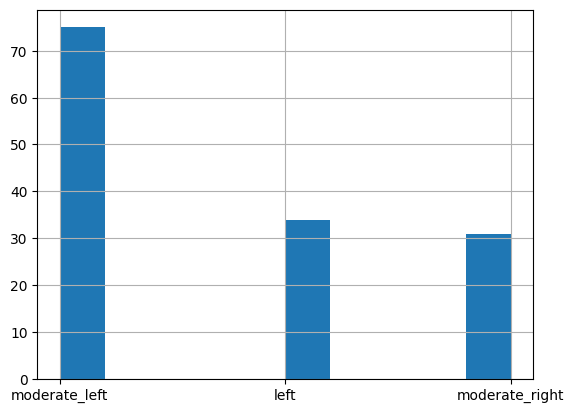

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Cuitlahuac_Ola2'].hist()

<Axes: >

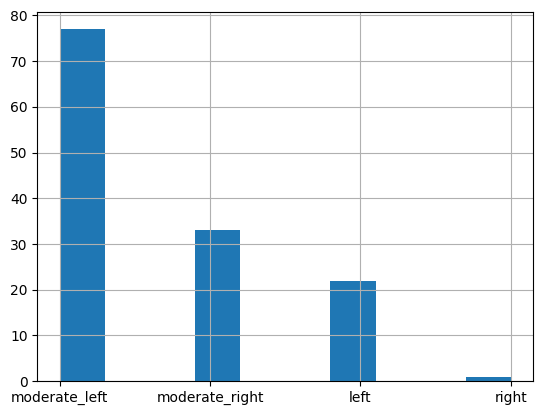

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Cuitlahuac_Ola3'].hist()

<Axes: >

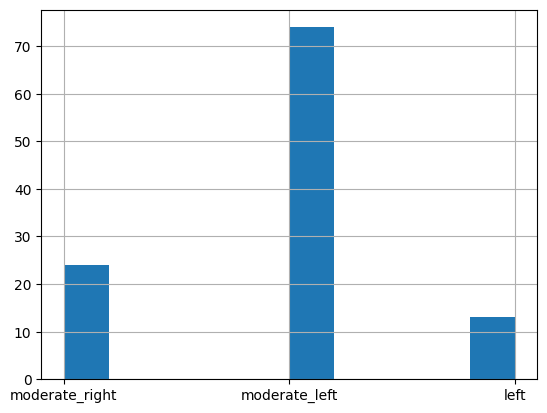

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Sinhue_Ola1'].hist()

<Axes: >

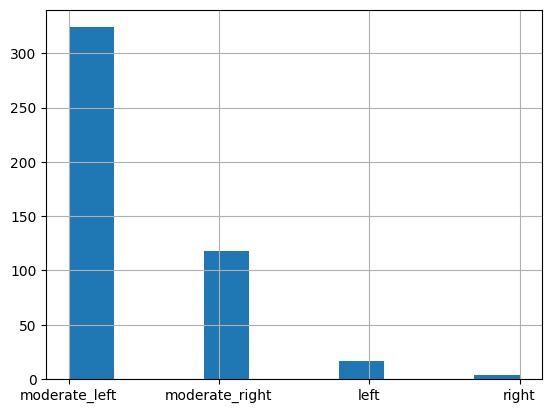

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Sinhue_Ola2'].hist()

<Axes: >

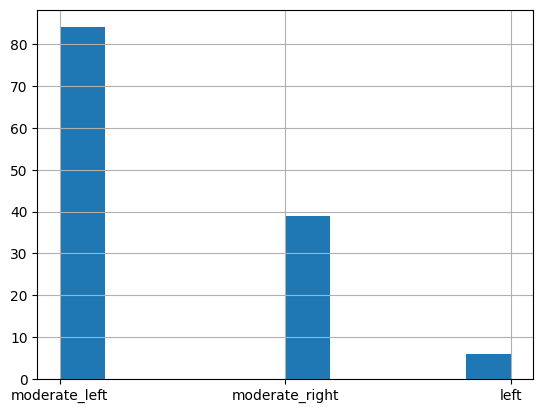

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Sinhue_Ola3'].hist()

<Axes: >

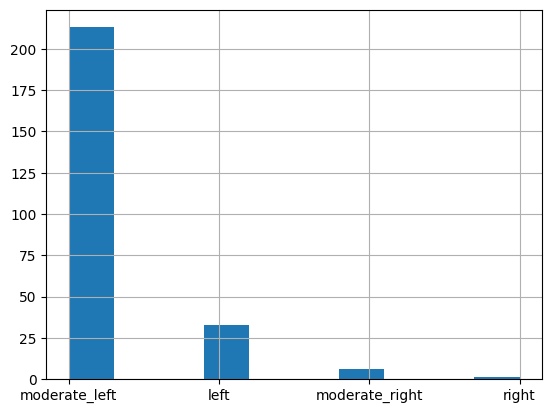

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Gattel_Ola1'].hist()

<Axes: >

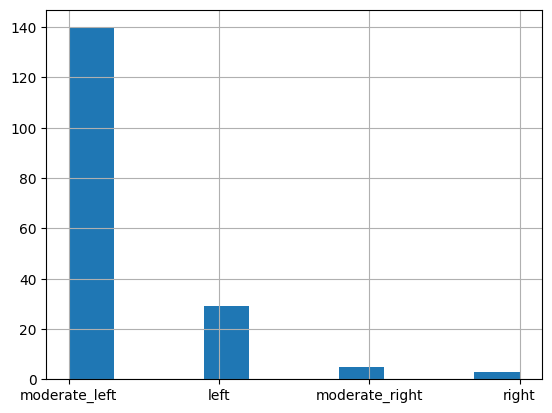

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Gattel_Ola2'].hist()

<Axes: >

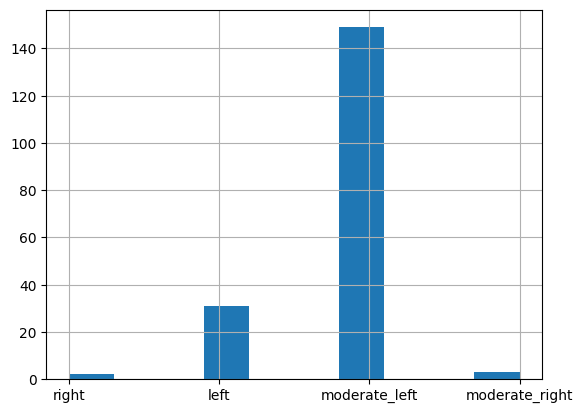

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Gattel_Ola3'].hist()

<Axes: >

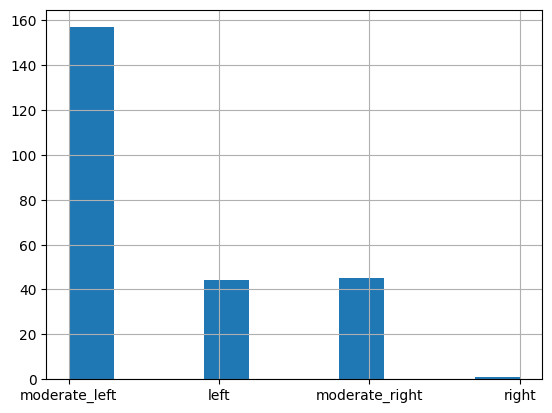

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Jaime_Ola1'].hist()

<Axes: >

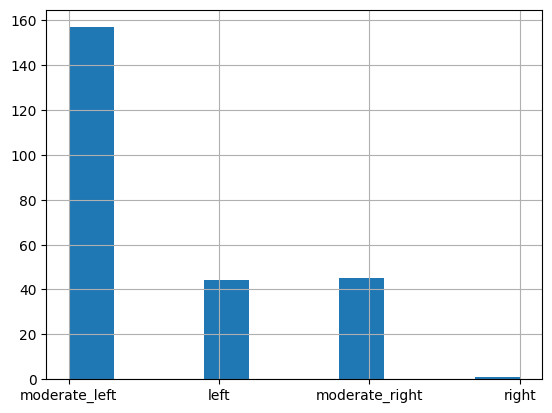

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Jaime_Ola2'].hist()

<Axes: >

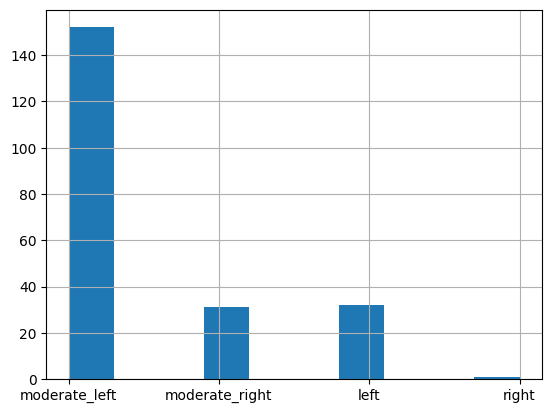

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Jaime_Ola3'].hist()

<Axes: >

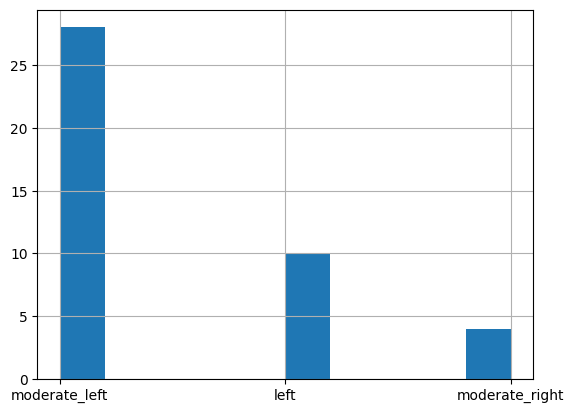

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Amlo_Ola1'].hist()

<Axes: >

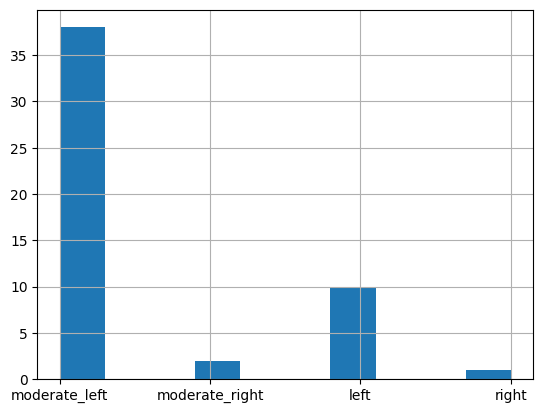

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Amlo_Ola2'].hist()

<Axes: >

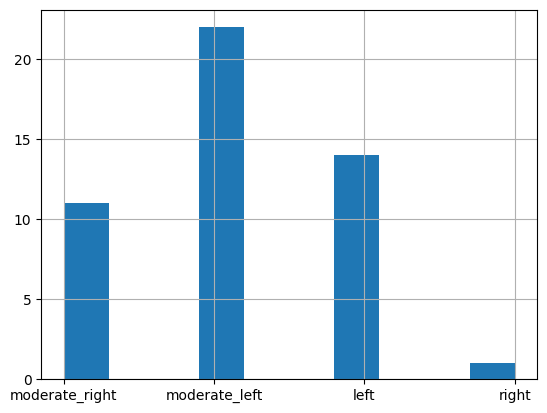

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Amlo_Ola3'].hist()

<Axes: >

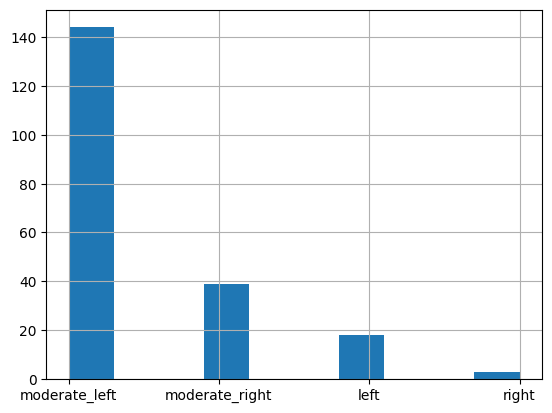

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Barbosa_Ola1'].hist()

<Axes: >

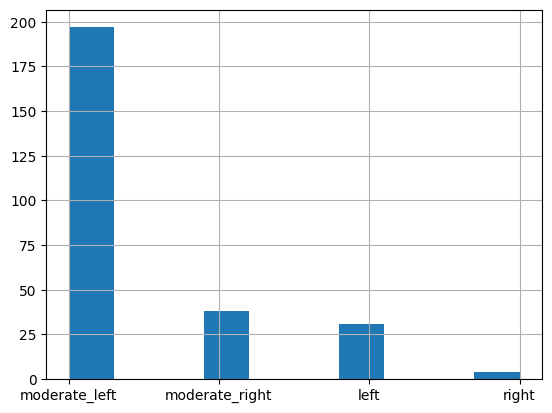

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Barbosa_Ola2'].hist()

<Axes: >

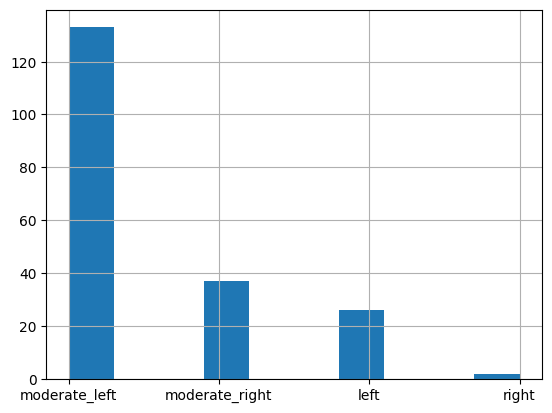

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Barbosa_Ola3'].hist()

<Axes: >

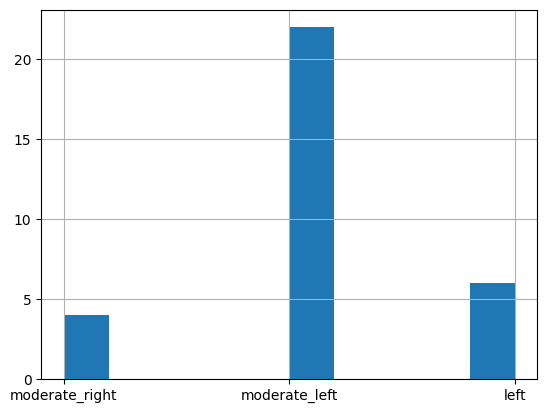

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Alejandro_Ola1'].hist()

<Axes: >

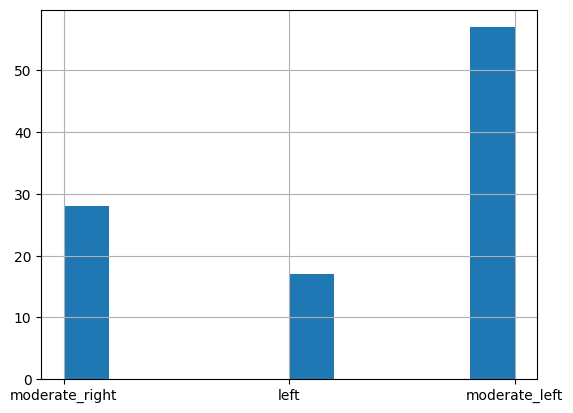

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Alejandro_Ola2'].hist()

<Axes: >

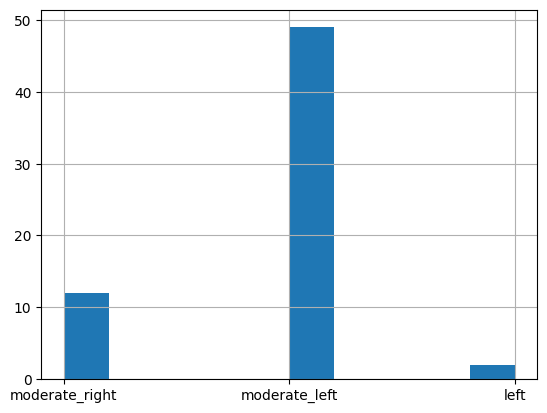

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Alejandro_Ola3'].hist()

###Mejor modelo

<Axes: >

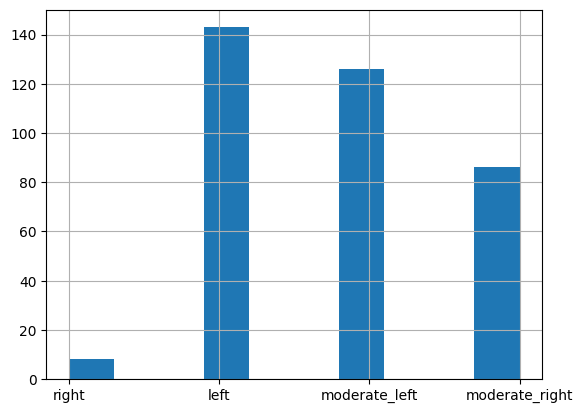

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Alfaro_Ola1'].hist()

<Axes: >

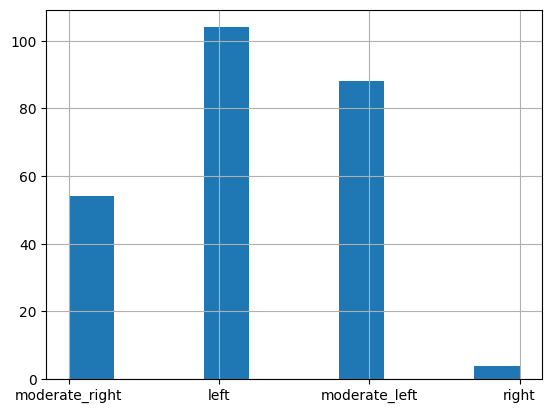

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Alfaro_Ola2'].hist()

<Axes: >

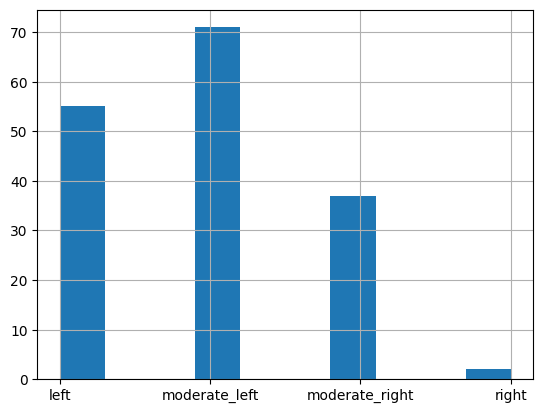

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Alfaro_Ola3'].hist()

<Axes: >

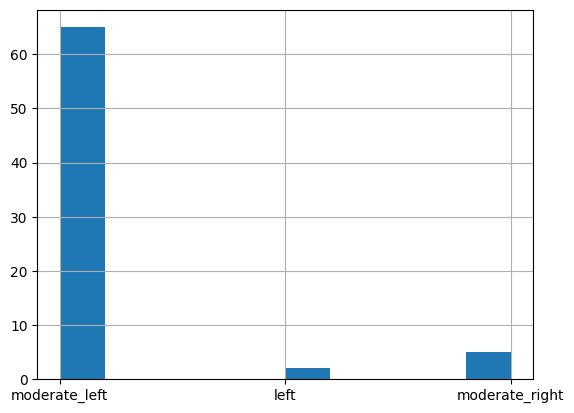

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Alfredo_Ola1'].hist()

<Axes: >

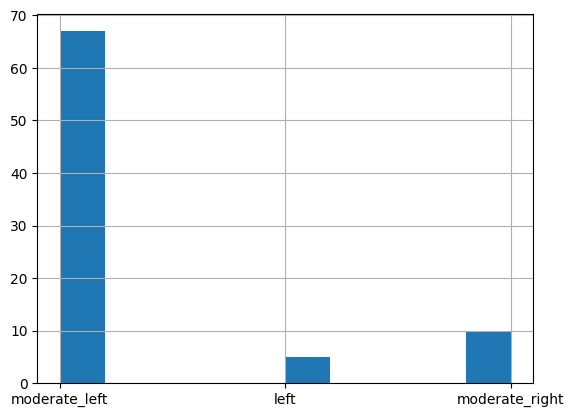

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Alfredo_Ola2'].hist()

<Axes: >

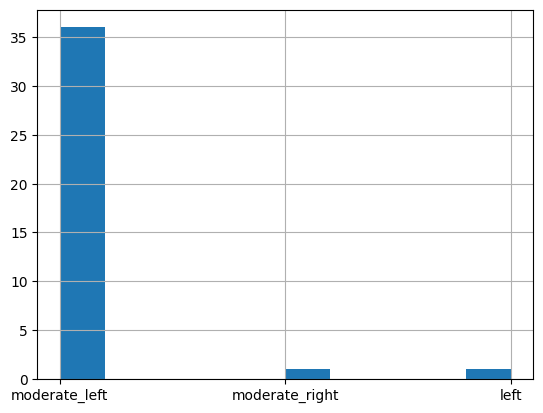

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Alfredo_Ola3'].hist()

<Axes: >

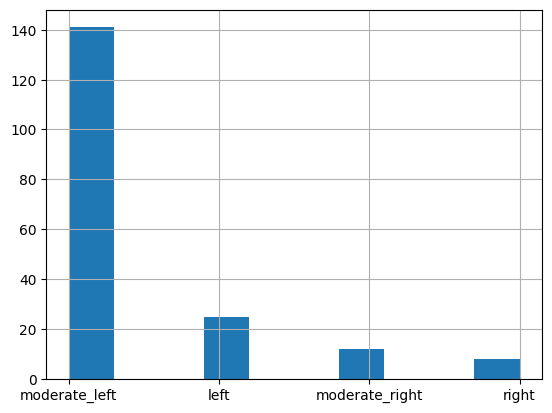

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Sheibaum_Ola1'].hist()

<Axes: >

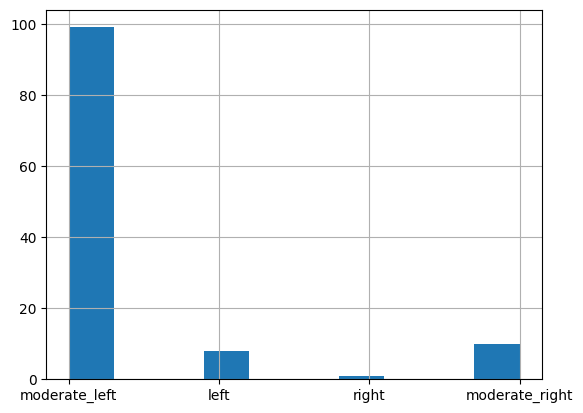

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Sheibaum_Ola2'].hist()

<Axes: >

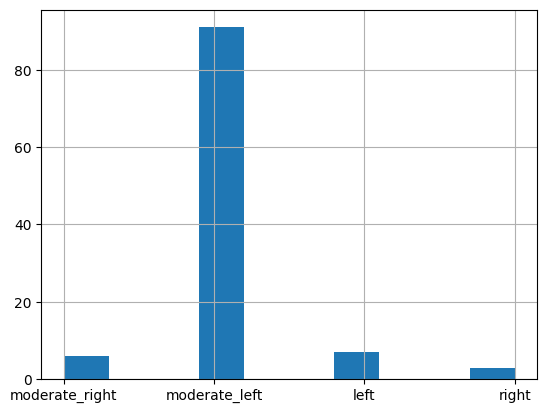

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Sheibaum_Ola3'].hist()

<Axes: >

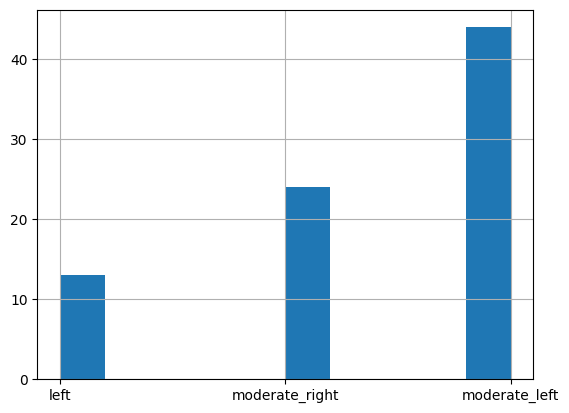

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Cuitlahuac_Ola1'].hist()

<Axes: >

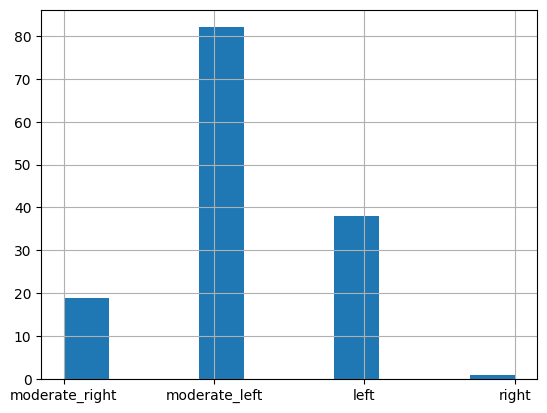

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Cuitlahuac_Ola2'].hist()

<Axes: >

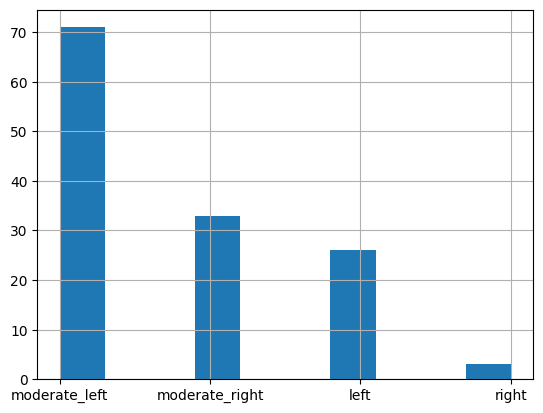

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Cuitlahuac_Ola3'].hist()

<Axes: >

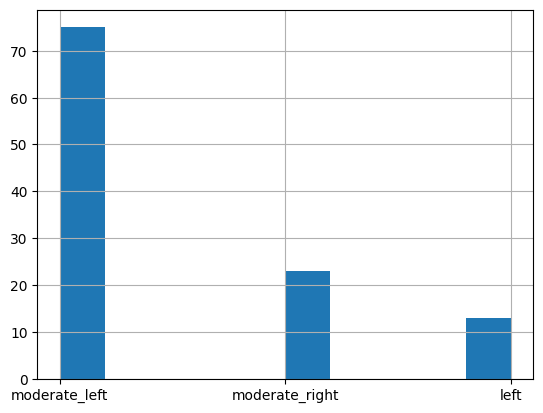

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Sinhue_Ola1'].hist()

<Axes: >

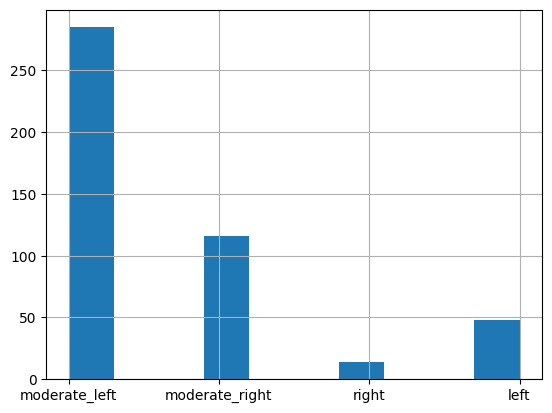

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Sinhue_Ola2'].hist()

<Axes: >

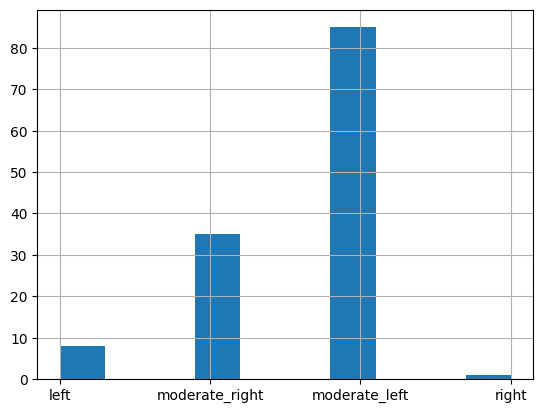

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Sinhue_Ola3'].hist()

<Axes: >

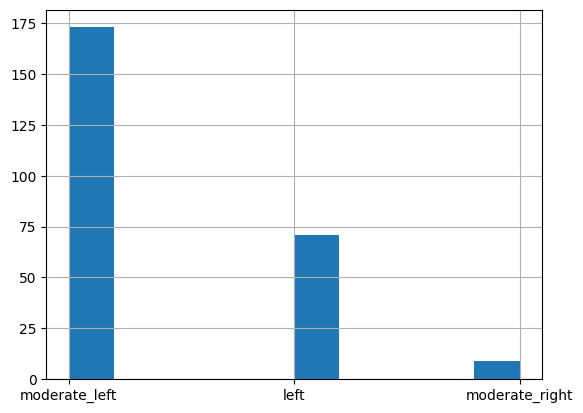

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Gattel_Ola1'].hist()

<Axes: >

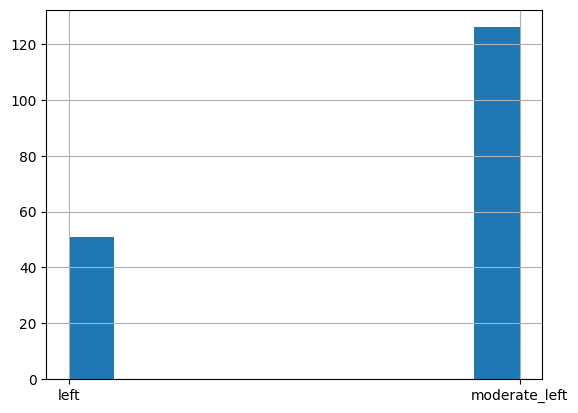

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Gattel_Ola2'].hist()

<Axes: >

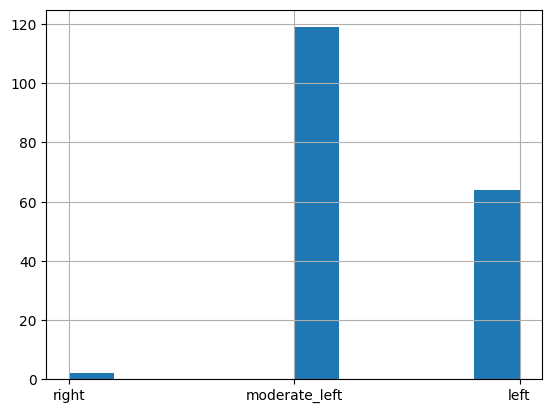

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Gattel_Ola3'].hist()

<Axes: >

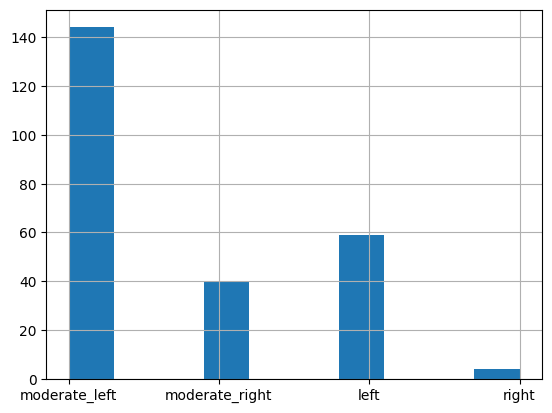

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Jaime_Ola1'].hist()

<Axes: >

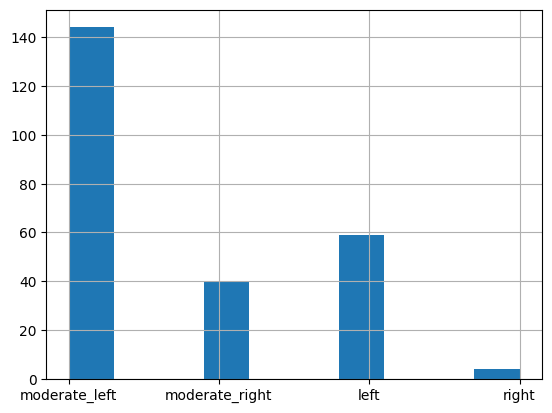

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Jaime_Ola2'].hist()

<Axes: >

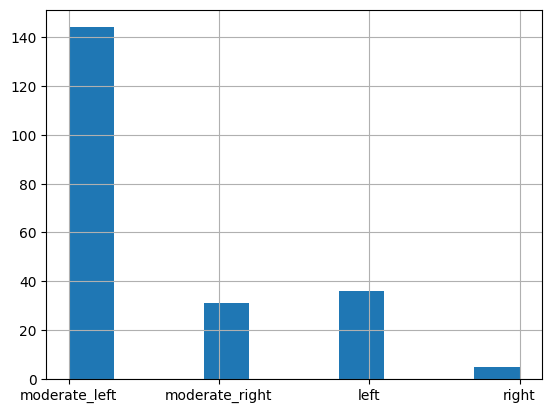

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Jaime_Ola3'].hist()

<Axes: >

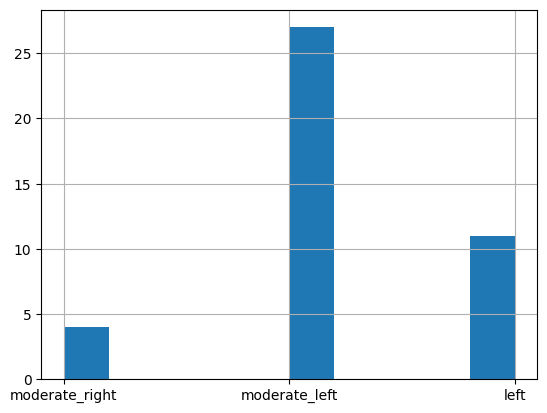

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Amlo_Ola1'].hist()

<Axes: >

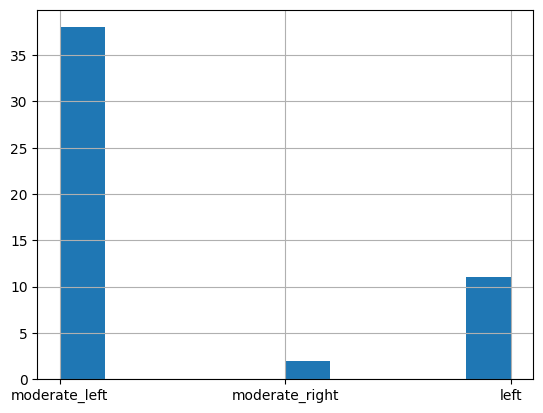

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Amlo_Ola2'].hist()

<Axes: >

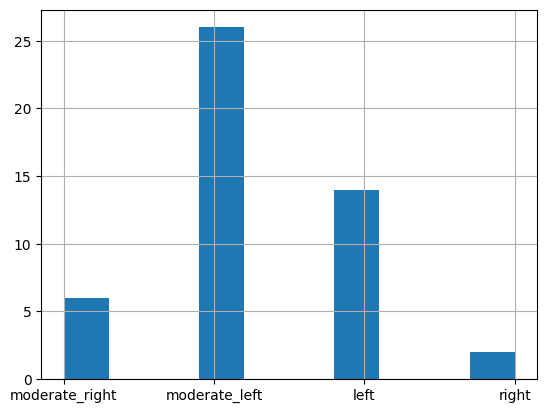

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Amlo_Ola3'].hist()

<Axes: >

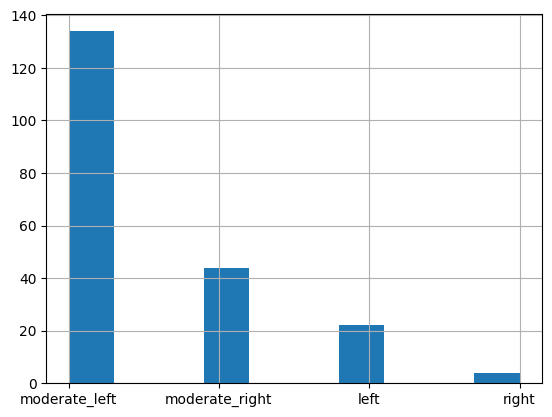

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Barbosa_Ola1'].hist()

<Axes: >

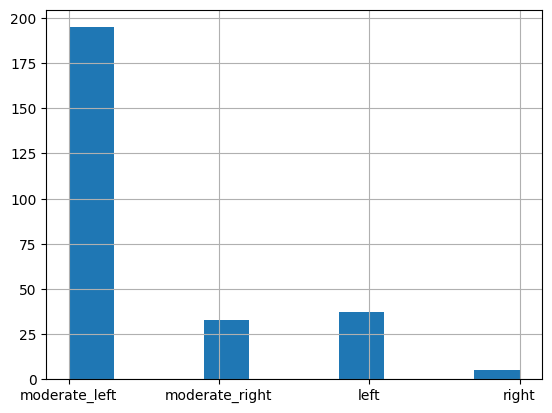

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Barbosa_Ola2'].hist()

<Axes: >

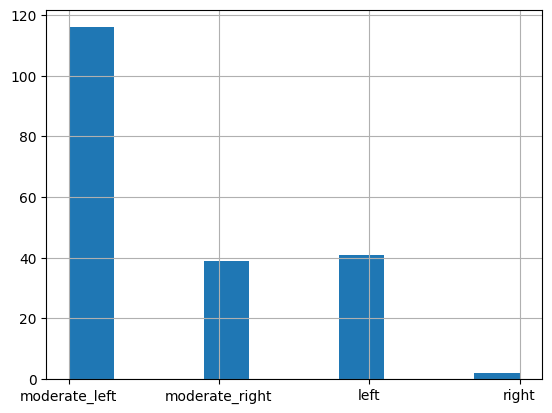

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Barbosa_Ola3'].hist()

<Axes: >

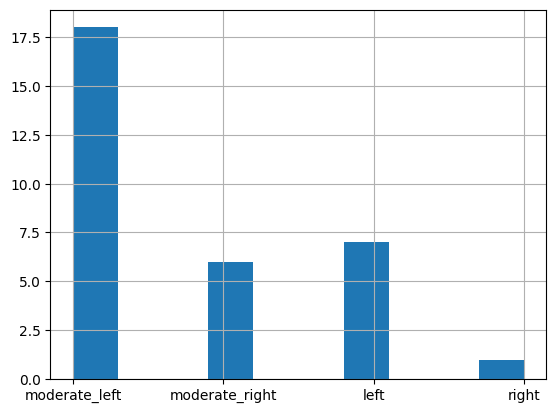

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Alejandro_Ola1'].hist()

<Axes: >

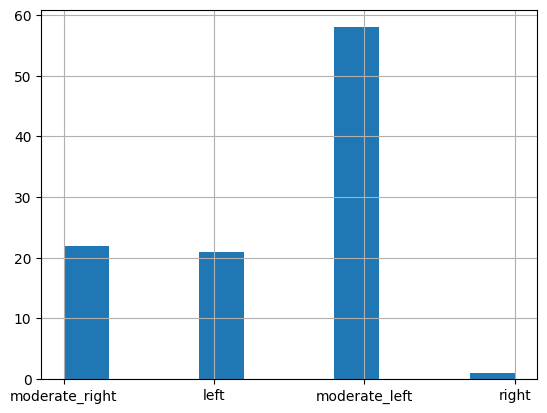

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Alejandro_Ola2'].hist()

<Axes: >

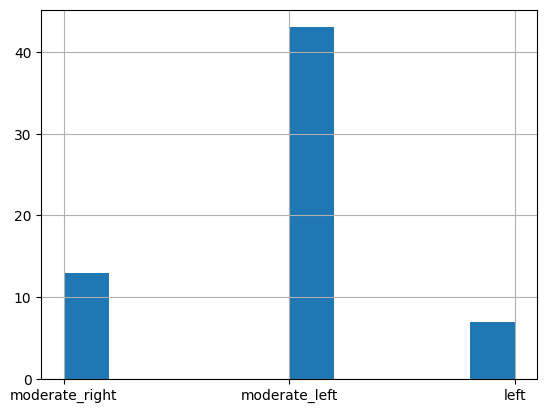

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Alejandro_Ola3'].hist()